In [0]:
#!pip install torchvision


In [0]:
import torch
import torchvision

In [3]:
# Preparing the Dataset

n_epochs = 4
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Processing...
Done!


In [0]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [6]:
example_data.shape

torch.Size([1000, 1, 28, 28])

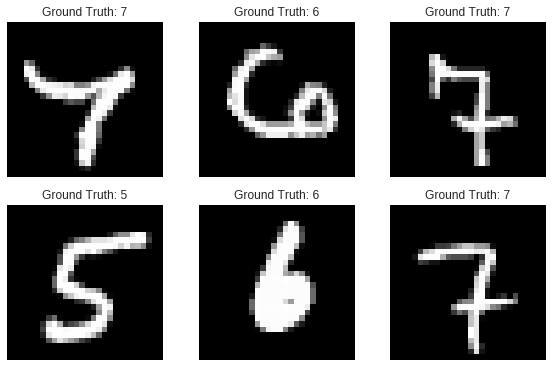

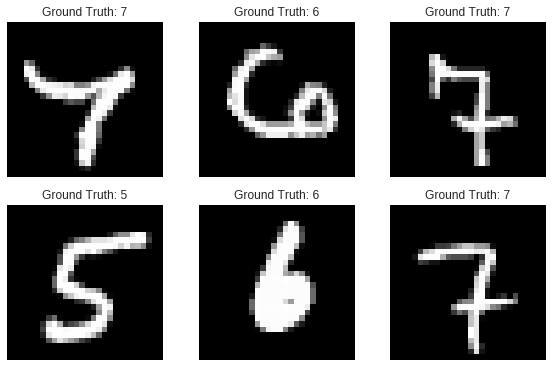

In [7]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


In [0]:
# Building the Network

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)
      

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [0]:
# Training the Model

train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [0]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      #torch.save(network.state_dict(), '/results/model.pth')
      #torch.save(optimizer.state_dict(), '/results/optimizer.pth')
      
      torch.save(network.state_dict(), 'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')

In [0]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [12]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3004, Accuracy: 751/10000 (7%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.268457
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.268337
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.274000
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.251669
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.236826
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.223578
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.153440
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.096371
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.974112
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.944348
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.839604
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.765901
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.699960
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.691150
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.509484
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.395923
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.286211
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.321333
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.273633
Train Epoch: 1 [12160/6

In [13]:
import numpy as np

print(np.shape(test_counter))
print(np.shape(test_losses))



(5,)
(5,)


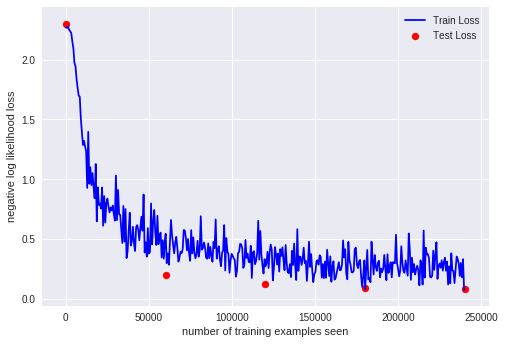

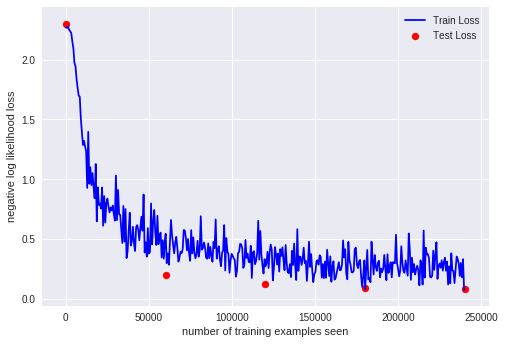

In [14]:
# Evaluating the Model's Performance

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [15]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


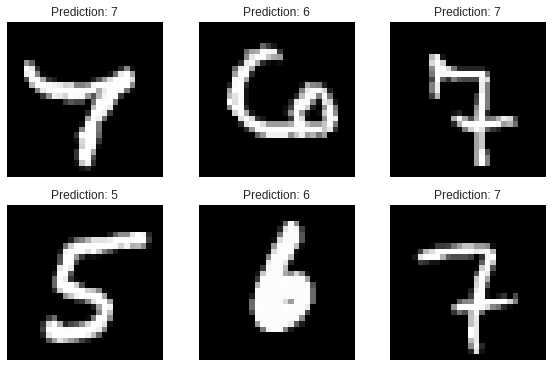

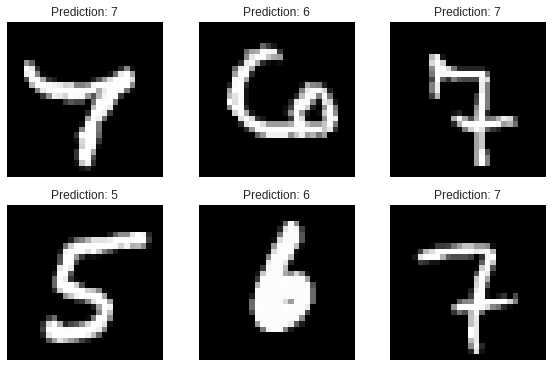

In [16]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [20]:
# Continued Training from Checkpoints

continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

'''
network_state_dict = torch.load($$ref{{["~:output","32ae962e-7ed7-4fe8-9a5b-3d90b89d6b09","model.pth"]}})
continued_network.load_state_dict(network_state_dict)

optimizer_state_dict = torch.load($$ref{{["~:output","32ae962e-7ed7-4fe8-9a5b-3d90b89d6b09","optimizer.pth"]}})
continued_optimizer.load_state_dict(optimizer_state_dict)
'''


'\nnetwork_state_dict = torch.load($$ref{{["~:output","32ae962e-7ed7-4fe8-9a5b-3d90b89d6b09","model.pth"]}})\ncontinued_network.load_state_dict(network_state_dict)\n\noptimizer_state_dict = torch.load($$ref{{["~:output","32ae962e-7ed7-4fe8-9a5b-3d90b89d6b09","optimizer.pth"]}})\ncontinued_optimizer.load_state_dict(optimizer_state_dict)\n'

In [18]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.274727
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.329944
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.132823
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.179801
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.164098
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.246006
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.184289
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.326047
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.198291
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.248087
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.215902
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.361257
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.216276
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.263075
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.171897
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.447970
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.151936
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.338710
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.316540
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.184744
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0730, Accuracy: 9782/10000 (97%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.350334
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.275022
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.125097
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.126795
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.102650
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.267139
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.285774
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.125007
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.201399
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.129993
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.173396
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.261889
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.258682
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.147433
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.279970
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.110762
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.112525
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.234941
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.172246
Train Epoch: 5 [12160

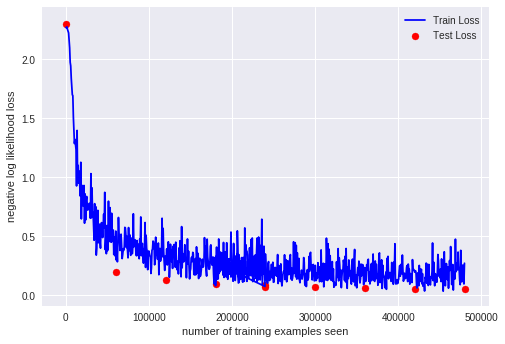

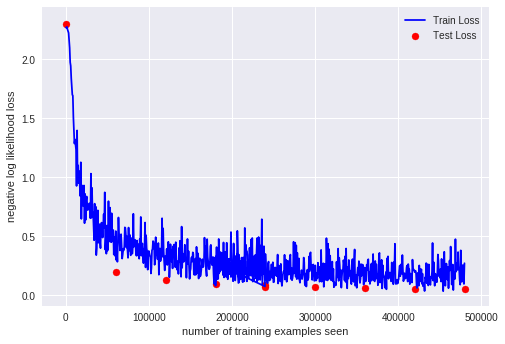

In [19]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig